In [1]:
import os, sys
from glob import glob
from utils import p2r, stack_features, word2sense, regression, cv_regression_w2s, image_to_tensor, Subject, listdir, correlation
import numpy as np
from tqdm import tqdm

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from collections import OrderedDict 
import string

In [18]:
# Cat's new word2vec (312 categories)
w2v = np.zeros((312, 300))

embedding_file = "ThingsWrd2Vec_subset.txt"
f = open(embedding_file, 'r', encoding='utf-8')
wordvec2lines = f.readlines()
f.close()

# Setup w2s
w2s_file = "ThingsWrd2Sns.txt"
_, w2s_embeddings = word2sense(w2s_file)
nDim = 2250

# Wordvec filtered by CM
wordvec2 = {}
for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word = (wordvec2lines[i].split(','))[0]
    if word in w2s_embeddings:
        wordvec2[word] = wordvec2lines[i].split(',')[1:]
        wordvec2[word][-1] = wordvec2[word][-1].replace('\n', '')

for wv in wordvec2:
    wordvec2[wv] = np.array(wordvec2[wv]).astype(np.float)
    

# Setup features
condition_features = np.load('features_all_unflattened.npy', allow_pickle=True)

nfeat = 0
for l in condition_features.item().get('aardvark'):
    if l.shape[0] == 4096:
        continue
    nfeat = nfeat + l.shape[0]
    print(l.shape)
print(nfeat)
features = np.zeros((len(wordvec2), nfeat))

idx = 0
for i, condition in enumerate(condition_features.item()):
    c_name = condition.split('/')[-1]
    if c_name in wordvec2:
        feat = 0
        for l, layer in enumerate(condition_features.item().get(condition)):
            if layer.shape[0] == 4096:
                continue
            for filt in range(layer.shape[0]):
                features[idx, feat] = np.amax(np.array(layer[filt]))
                feat = feat + 1
        idx = idx + 1

# Setup voxels
voxels = np.zeros((312, 200))
idx = 0
for i, c in enumerate(condition_features.item()):
    c_name = c.split('/')[-1]
    if c_name in wordvec2:
        voxel = np.load('./predicted_EVC_conv5' + '/' + c_name + '/' + c_name + '.npy')
        #print(voxel.shape)
        voxels[idx, :] = voxel
        w2v[idx, :] = wordvec2[c_name]
        idx = idx + 1
        
print(voxels)
print(w2v)

torch.Size([192, 15, 15])
torch.Size([384, 15, 15])
torch.Size([256, 15, 15])
torch.Size([256, 7, 7])
1088
[[ 0.849549    0.96951175  0.58117616 ... -0.94369125 -0.75475496
  -0.85556436]
 [ 1.20531619  1.20672095  1.05386639 ...  0.03004985  0.23561852
   0.0700088 ]
 [ 0.42336887  0.45317259  0.32649446 ...  0.06753058  0.27266392
   0.16944927]
 ...
 [-0.19829036 -0.15589269 -0.23279606 ... -0.57010037 -0.52042735
  -0.42235258]
 [ 0.1947265   0.24973315  0.20636265 ...  0.24672724  0.29079354
   0.33893663]
 [-0.04339194 -0.05269252 -0.03452642 ... -0.85805517 -0.64671129
  -0.78481632]]
[[ 0.01977539 -0.02392578  0.07324219 ...  0.13671875 -0.18359375
  -0.09619141]
 [ 0.13378906  0.08984375 -0.16308594 ...  0.12207031 -0.30859375
   0.21484375]
 [-0.03515625  0.15234375 -0.12402344 ... -0.04956055 -0.1640625
  -0.03222656]
 ...
 [-0.17578125 -0.109375   -0.18945312 ... -0.0378418   0.30859375
   0.05004883]
 [-0.03833008 -0.27734375 -0.18652344 ... -0.02502441 -0.11962891
   0.15

In [20]:
feat_by_voxel = np.zeros((nfeat, 200))
feat_by_dim = np.zeros((nfeat, 300))



for i in range(nfeat):
    for j in range(200):
        feat_by_voxel[i, j] = (correlation(features[:, i], voxels[:, j]))

for i in range(nfeat):
    for j in range(300):
        feat_by_dim[i, j] = (correlation(features[:, i], w2v[:, j]))

r_threshold1 = p2r(0.05/200, 1470)
r_threshold2 = p2r(0.05/300, 1470)

In [21]:
feat_by_voxel_score = np.zeros(nfeat)
feat_by_dim_score = np.zeros(nfeat)

for n in range(nfeat):
    feat_by_voxel_score[n] = (np.sum(feat_by_voxel[n, :] > r_threshold1))
    feat_by_dim_score[n] = (np.sum(feat_by_dim[n, :] > r_threshold2))

feat_by_voxel_max = np.zeros(nfeat)
feat_by_dim_max = np.zeros(nfeat)

for n in range(nfeat):
    feat_by_voxel_max[n] = np.nanmax(feat_by_voxel[n, :])
    feat_by_dim_max[n] = np.nanmax(feat_by_dim[n, :])

feat_by_voxel_mean = np.zeros(nfeat)
feat_by_dim_mean = np.zeros(nfeat)

for n in range(nfeat):
    feat_by_voxel_mean[n] = np.nanmean(feat_by_voxel[n, :])
    feat_by_dim_mean[n] = np.nanmean(feat_by_dim[n, :])

feat_by_voxel_median = np.zeros(nfeat)
feat_by_dim_median = np.zeros(nfeat)

for n in range(nfeat):
    feat_by_voxel_median[n] = np.nanmedian(feat_by_voxel[n, :])
    feat_by_dim_median[n] = np.nanmedian(feat_by_dim[n, :])

-0.20475174065174911
-0.5768749064319071
0.002005730255012302
-0.46761435427532766


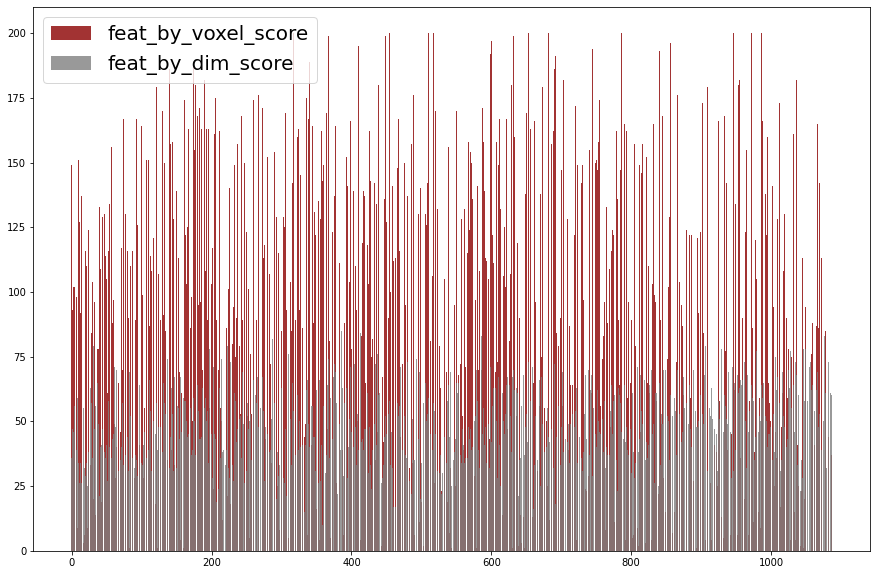

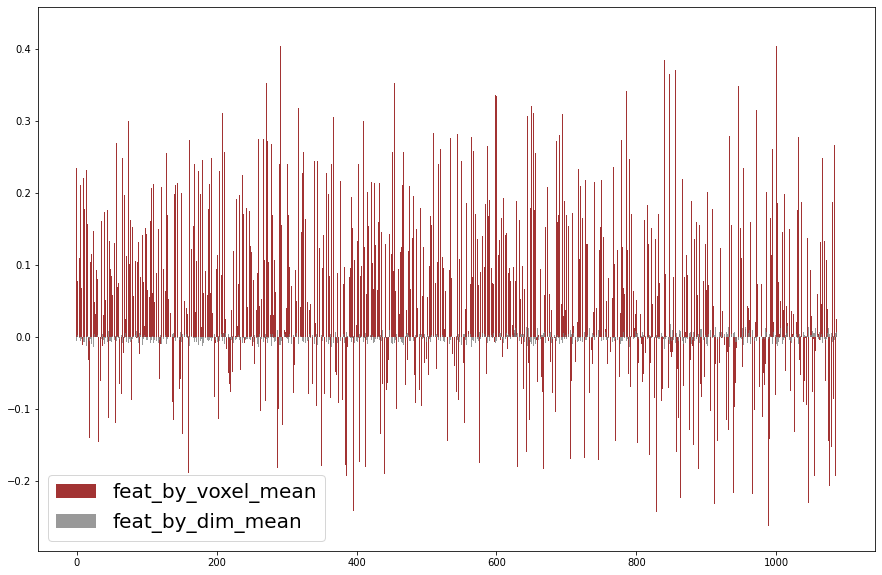

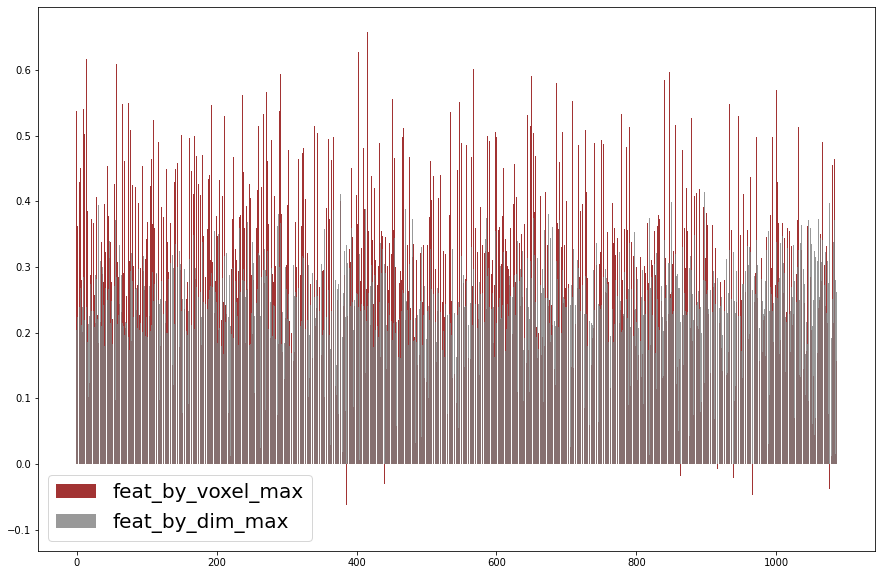

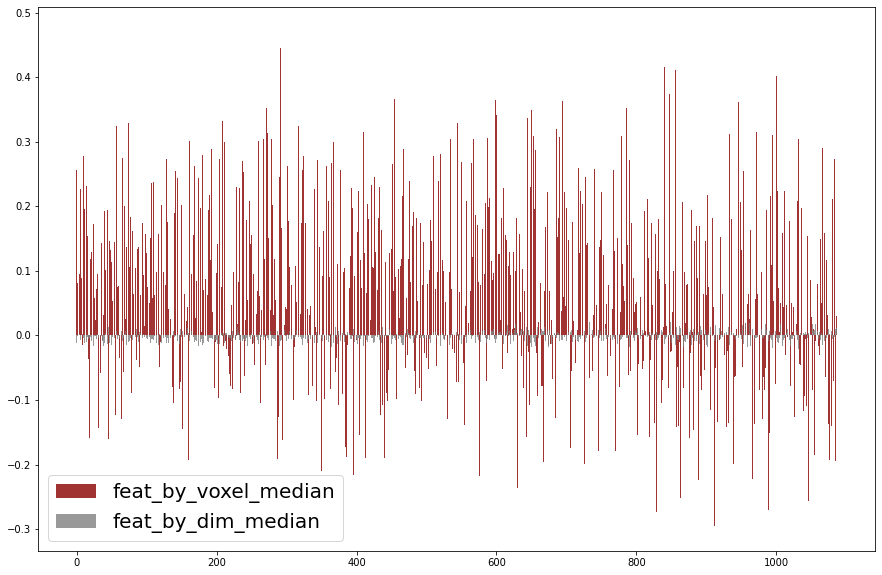

In [22]:
print(correlation(feat_by_voxel_score, feat_by_dim_score))
print(correlation(feat_by_voxel_mean, feat_by_dim_mean))
print(correlation(feat_by_voxel_max, feat_by_dim_max))
print(correlation(feat_by_voxel_median, feat_by_dim_median))


fig = plt.figure(figsize=(15, 10))
plt.title("Correlation between CNN feature and neural space (semantic dimensionality score)")
plt.bar(range(0,nfeat), feat_by_voxel_score, color='darkred', label='feat_by_voxel_score', alpha=0.8)
plt.bar(range(0,nfeat), feat_by_dim_score, color='grey', label='feat_by_dim_score', alpha=0.8)
plt.legend(prop={'size': 20})
plt.show()


fig = plt.figure(figsize=(15, 10))
plt.bar(range(0,nfeat), feat_by_voxel_mean, color='darkred', label='feat_by_voxel_mean', alpha=0.8)
plt.bar(range(0,nfeat), feat_by_dim_mean, color='grey', label='feat_by_dim_mean', alpha=0.8)
plt.legend(prop={'size': 20})
plt.show()

fig = plt.figure(figsize=(15, 10))
plt.bar(range(0,nfeat), feat_by_voxel_max, color='darkred', label='feat_by_voxel_max', alpha=0.8)
plt.bar(range(0,nfeat), feat_by_dim_max, color='grey', label='feat_by_dim_max', alpha=0.8)
plt.legend(prop={'size': 20})
plt.show()


fig = plt.figure(figsize=(15, 10))
plt.bar(range(0,nfeat), feat_by_voxel_median, color='darkred', label='feat_by_voxel_median', alpha=0.8)
plt.bar(range(0,nfeat), feat_by_dim_median, color='grey', label='feat_by_dim_median', alpha=0.8)
plt.legend(prop={'size': 20})
plt.show()